In [ ]:
# Necessary installments for pandas_ta library to work...

!pip uninstall numpy -y
!pip install numpy==1.26.4  # Downgrade to a stable version
!pip uninstall pandas_ta -y
!pip install pandas_ta --no-cache-dir

# RESTART RUNTIME (ΠΕΡΙΟΔΟΣ ΛΕΙΤΟΥΡΓΙΑΣ) AFTER PANDAS_TA IS INSTALLED AND THEN RUN THE REST OF THE CELLS

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 434.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 32.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=0b988f625190f33588ac69ad83b51aef3e3389b530e50ffaa92a99d23e63d68e
  Stored in directory: /tmp/pip-ephem-wheel-cache-3z6sntuo/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


In [ ]:
import requests
import numpy as np
import pandas as pd
import pandas_ta as ta
from datetime import date
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Read, clean the data and calculate btc volatility & technical indicators


# Download Fear and Greed Index data
url = 'https://api.alternative.me/fng/?limit=0&format=json'
response = requests.get(url)
data = response.json()

# Parse the data
fear_greed = pd.DataFrame(data['data'])
fear_greed['timestamp'] = pd.to_datetime(fear_greed['timestamp'].astype(int), unit='s').dt.date
fear_greed.set_index('timestamp', inplace=True)
fear_greed['value'] = fear_greed['value'].astype(int)
fear_greed = fear_greed[['value']]
fear_greed.columns = ['FearGreedIndex']
fear_greed = fear_greed.rename_axis('Date')

# Clean the data
btc = pd.read_csv('/BTC-USD.csv', thousands = ',')[['Date','Price','Vol.']]
sp500 = pd.read_csv('/S&P 500.csv', thousands = ',')[['Date','Price']]
nasdaq = pd.read_csv('/NASDAQ.csv', thousands = ',')[['Date','Price']]
gold = pd.read_csv('/GOLD.csv', thousands = ',')[['Date','Price']]
dxy = pd.read_csv('/DXY.csv', thousands = ',')[['Date','Price']]
tnx = pd.read_csv('/TNX.csv', thousands = ',')[['Date','Price']]
vix = pd.read_csv('/VIX.csv', thousands = ',')[['Date','Price']]

btc['Vol.'] = btc['Vol.'].str.replace('K','').astype(float)
btc['Vol.'] = btc['Vol.']*1000

# Convert the date to datetime
btc['Date'] =  pd.to_datetime(btc['Date']).dt.date
sp500['Date'] =  pd.to_datetime(sp500['Date']).dt.date
nasdaq['Date'] =  pd.to_datetime(nasdaq['Date']).dt.date
gold['Date'] =  pd.to_datetime(gold['Date']).dt.date
dxy['Date'] =  pd.to_datetime(dxy['Date']).dt.date
tnx['Date'] =  pd.to_datetime(tnx['Date']).dt.date
vix['Date'] =  pd.to_datetime(vix['Date']).dt.date


# Set 'Date' as the index
btc.set_index('Date', inplace=True)
sp500.set_index('Date', inplace=True)
nasdaq.set_index('Date', inplace=True)
gold.set_index('Date', inplace=True)
dxy.set_index('Date', inplace=True)
tnx.set_index('Date', inplace=True)
vix.set_index('Date', inplace=True)

# Rename columns
btc.rename(columns={'Price': 'BTC', 'Vol.': 'Volume'},inplace=True)
sp500.rename(columns={'Price': 'SP500'},inplace=True)
nasdaq.rename(columns={'Price': 'NASDAQ'},inplace=True)
gold.rename(columns={'Price': 'GOLD'},inplace=True)
dxy.rename(columns={'Price': 'DXY'},inplace=True)
tnx.rename(columns={'Price': 'TNX'},inplace=True)
vix.rename(columns={'Price': 'VIX'},inplace=True)


# Start with the first DataFrame (btc) and merge the others on 'Date'
og_data = pd.merge(btc, sp500, on='Date', how='left')  # 'inner' keeps only matching dates
og_data = pd.merge(og_data, nasdaq, on='Date', how='left')
og_data = pd.merge(og_data, gold, on='Date', how='left')
og_data = pd.merge(og_data, dxy, on='Date', how='left')
og_data = pd.merge(og_data, tnx, on='Date', how='left')
og_data = pd.merge(og_data, vix, on='Date', how='left')
og_data = pd.merge(og_data, fear_greed, on='Date', how='left')

# Sort by date
og_data = og_data.sort_values(by="Date", ascending = True)

# First calculate daily returns
og_data['BTC_Volatility'] = og_data['BTC'].pct_change(fill_method=None).rolling(window=14).std()

#Calculate RSI
og_data["RSI"] = ta.rsi(og_data["BTC"], length=14)

#Calculate SMAs
og_data["SMA_50"] = ta.sma(og_data["BTC"], length=50)
og_data["SMA_100"] = ta.sma(og_data["BTC"], length=100)
og_data["SMA_200"] = ta.sma(og_data["BTC"], length=200)

#Calculate Bollinger Bands
bbands = ta.bbands(og_data["BTC"], length=20, std=2)
og_data["BB_upper"] = bbands["BBU_20_2.0"]
og_data["BB_middle"] = bbands["BBM_20_2.0"]
og_data["BB_lower"] = bbands["BBL_20_2.0"]



In [ ]:
og_data.tail(10)

,BTC,Volume,SP500,NASDAQ,GOLD,DXY,TNX,VIX,FearGreedIndex,BTC_Volatility,RSI,SMA_50,SMA_100,SMA_200,BB_upper,BB_middle,BB_lower
Date,,,,,,,,,,,,,,,,,
2025-04-22,93303.0,1040.0,5287.76,18276.41,3419.40,98.92,43.89,30.57,47.0,0.032402,67.361358,84306.78,90989.28,88456.690,90421.107651,83557.20,76693.292349
2025-04-23,93639.0,1300.0,5375.86,18693.26,3294.10,99.84,43.87,28.45,72.0,0.026210,67.803712,84430.12,90978.85,88614.195,92223.514228,84079.60,75935.685772
2025-04-24,93940.0,340.0,5484.77,19214.40,3348.60,99.38,43.05,26.47,63.0,0.022838,68.219253,84491.96,90951.24,88769.425,93789.850244,84584.55,75379.249756
2025-04-25,94702.0,710.0,5525.21,19432.56,3298.40,99.47,42.66,24.84,60.0,0.020380,69.299507,84583.60,90893.36,88931.590,95327.118019,85139.75,74952.381981
2025-04-26,94693.0,310.0,NaN,NaN,NaN,NaN,NaN,NaN,65.0,0.020143,69.269559,84737.18,90839.89,89093.900,96460.416374,85952.35,75444.283626
2025-04-27,93784.0,400.0,NaN,NaN,NaN,NaN,NaN,NaN,61.0,0.019380,66.159662,84883.00,90737.33,89259.570,97236.347403,86682.50,76128.652597
2025-04-28,95046.0,1340.0,5528.75,19427.29,3347.70,99.01,42.16,25.15,54.0,0.019423,68.288307,85166.06,90642.89,89433.115,97640.406017,87618.20,77595.993983
2025-04-29,94451.0,500.0,5560.83,19544.95,3347.60,99.24,41.73,24.17,60.0,0.019143,66.174801,85480.40,90573.80,89592.465,98372.894091,88213.65,78054.405909
2025-04-30,94309.0,1140.0,5569.06,19571.02,3281.37,99.47,41.77,24.70,56.0,0.019310,65.652568,85703.74,90495.19,89747.335,98619.031486,88951.45,79283.868514


In [ ]:
# Calculate next-day return
og_data['future_return'] = og_data['BTC'].shift(-1) / og_data['BTC'] - 1

# Define label function
def label_return(r):
    if r < -0.02:
        return 'Strong Sell'
    elif -0.02 <= r < -0.005:
        return 'Sell'
    elif -0.005 <= r <= 0.005:
        return 'Neutral'
    elif 0.005 < r <= 0.02:
        return 'Buy'
    else:
        return 'Strong Buy'

# Apply the label function
og_data['target'] = og_data['future_return'].apply(label_return)

og_data.tail(10)

,BTC,Volume,SP500,NASDAQ,GOLD,DXY,TNX,VIX,FearGreedIndex,BTC_Volatility,RSI,SMA_50,SMA_100,SMA_200,BB_upper,BB_middle,BB_lower,future_return,target
Date,,,,,,,,,,,,,,,,,,,
2025-04-22,93303.0,1040.0,5287.76,18276.41,3419.40,98.92,43.89,30.57,47.0,0.032402,67.361358,84306.78,90989.28,88456.690,90421.107651,83557.20,76693.292349,0.003601,Neutral
2025-04-23,93639.0,1300.0,5375.86,18693.26,3294.10,99.84,43.87,28.45,72.0,0.026210,67.803712,84430.12,90978.85,88614.195,92223.514228,84079.60,75935.685772,0.003214,Neutral
2025-04-24,93940.0,340.0,5484.77,19214.40,3348.60,99.38,43.05,26.47,63.0,0.022838,68.219253,84491.96,90951.24,88769.425,93789.850244,84584.55,75379.249756,0.008112,Buy
2025-04-25,94702.0,710.0,5525.21,19432.56,3298.40,99.47,42.66,24.84,60.0,0.020380,69.299507,84583.60,90893.36,88931.590,95327.118019,85139.75,74952.381981,-0.000095,Neutral
2025-04-26,94693.0,310.0,NaN,NaN,NaN,NaN,NaN,NaN,65.0,0.020143,69.269559,84737.18,90839.89,89093.900,96460.416374,85952.35,75444.283626,-0.009599,Sell
2025-04-27,93784.0,400.0,NaN,NaN,NaN,NaN,NaN,NaN,61.0,0.019380,66.159662,84883.00,90737.33,89259.570,97236.347403,86682.50,76128.652597,0.013456,Buy
2025-04-28,95046.0,1340.0,5528.75,19427.29,3347.70,99.01,42.16,25.15,54.0,0.019423,68.288307,85166.06,90642.89,89433.115,97640.406017,87618.20,77595.993983,-0.006260,Sell
2025-04-29,94451.0,500.0,5560.83,19544.95,3347.60,99.24,41.73,24.17,60.0,0.019143,66.174801,85480.40,90573.80,89592.465,98372.894091,88213.65,78054.405909,-0.001503,Neutral
2025-04-30,94309.0,1140.0,5569.06,19571.02,3281.37,99.47,41.77,24.70,56.0,0.019310,65.652568,85703.74,90495.19,89747.335,98619.031486,88951.45,79283.868514,0.021822,Strong Buy


In [ ]:
# Drop null values for model training

og_data2 = og_data.dropna()

og_data2.tail(10)

,BTC,Volume,SP500,NASDAQ,GOLD,DXY,TNX,VIX,FearGreedIndex,BTC_Volatility,RSI,SMA_50,SMA_100,SMA_200,BB_upper,BB_middle,BB_lower,future_return,target
Date,,,,,,,,,,,,,,,,,,,
2025-04-16,84021.0,340.0,5275.70,18257.64,3346.40,99.38,42.79,32.64,29.0,0.035733,50.875654,84338.54,91480.30,87727.490,87203.441119,82578.75,77954.058881,0.009593,Buy
2025-04-17,84827.0,650.0,5282.70,18258.09,3328.40,99.38,43.33,29.65,30.0,0.035751,52.450895,84345.68,91358.51,87822.815,87239.314218,82591.45,77943.585782,-0.005470,Sell
2025-04-21,87473.0,920.0,5158.20,17808.30,3425.30,98.28,44.05,33.82,39.0,0.031391,58.082248,84170.22,91001.99,88301.130,88229.669215,83016.70,77803.730785,0.066649,Strong Buy
2025-04-22,93303.0,1040.0,5287.76,18276.41,3419.40,98.92,43.89,30.57,47.0,0.032402,67.361358,84306.78,90989.28,88456.690,90421.107651,83557.20,76693.292349,0.003601,Neutral
2025-04-23,93639.0,1300.0,5375.86,18693.26,3294.10,99.84,43.87,28.45,72.0,0.026210,67.803712,84430.12,90978.85,88614.195,92223.514228,84079.60,75935.685772,0.003214,Neutral
2025-04-24,93940.0,340.0,5484.77,19214.40,3348.60,99.38,43.05,26.47,63.0,0.022838,68.219253,84491.96,90951.24,88769.425,93789.850244,84584.55,75379.249756,0.008112,Buy
2025-04-25,94702.0,710.0,5525.21,19432.56,3298.40,99.47,42.66,24.84,60.0,0.020380,69.299507,84583.60,90893.36,88931.590,95327.118019,85139.75,74952.381981,-0.000095,Neutral
2025-04-28,95046.0,1340.0,5528.75,19427.29,3347.70,99.01,42.16,25.15,54.0,0.019423,68.288307,85166.06,90642.89,89433.115,97640.406017,87618.20,77595.993983,-0.006260,Sell
2025-04-29,94451.0,500.0,5560.83,19544.95,3347.60,99.24,41.73,24.17,60.0,0.019143,66.174801,85480.40,90573.80,89592.465,98372.894091,88213.65,78054.405909,-0.001503,Neutral


In [ ]:
# Selecting relevant features from the original dataset 'og_data2'
# These include market indices, technical indicators, sentiment measures, and BTC-specific indicators

X = og_data2[
        [
        'Volume', 'SP500', 'NASDAQ', 'GOLD', 'DXY', 'TNX', 'VIX', 'FearGreedIndex', 'BTC_Volatility',

        'RSI','SMA_50', 'SMA_100', 'SMA_200', 'BB_upper', 'BB_middle', 'BB_lower'

        ]]

# Encoding the target variable ('target') to numeric form (e.g., 0/1 or 0/1/2, depending on classes)
le = LabelEncoder()
y = le.fit_transform(og_data2['target'])


# Splitting the dataset into training and testing sets
# shuffle=False is used to preserve any time-series nature in the data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Standardizing the feature values (mean = 0, std = 1) to improve model performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initializing and training a Random Forest Classifier
# n_estimators=100: use 100 decision trees
# max_depth=50: limit tree depth to reduce overfitting
# random_state=42: ensures reproducibility
model = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, random_state=42)

              precision    recall  f1-score   support

         Buy       0.23      0.04      0.07        72
     Neutral       0.25      0.52      0.34        84
        Sell       0.24      0.29      0.27        79
  Strong Buy       0.32      0.10      0.15        70
 Strong Sell       0.27      0.26      0.27        57

    accuracy                           0.25       362
   macro avg       0.26      0.24      0.22       362
weighted avg       0.26      0.25      0.22       362



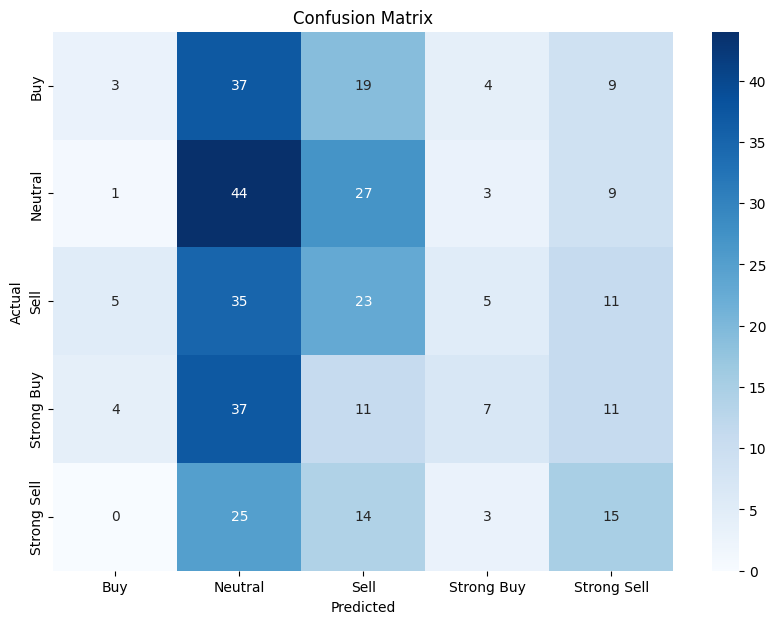

In [ ]:
y_pred = model.predict(X_test)

# Decode predictions and true values
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

# Print classification report
print(classification_report(y_test_labels, y_pred_labels))

# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Select the latest available feature row
latest_data = og_data2[[
    'Volume', 'SP500', 'NASDAQ', 'GOLD', 'DXY', 'TNX', 'VIX', 'FearGreedIndex', 'BTC_Volatility',
    'RSI','SMA_50', 'SMA_100', 'SMA_200', 'BB_upper', 'BB_middle', 'BB_lower'
]].iloc[-1]

# Scale the latest input
latest_data_scaled = scaler.transform([latest_data])

# Make prediction
prediction = model.predict(latest_data_scaled)
predicted_label = le.inverse_transform(prediction)[0]

print(f"📈 Predicted next-day signal: {predicted_label}")


📈 Predicted next-day signal: Sell


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


target
Buy            0.198562
Neutral        0.207412
Sell           0.191372
Strong Buy     0.212389
Strong Sell    0.190265
Name: proportion, dtype: float64


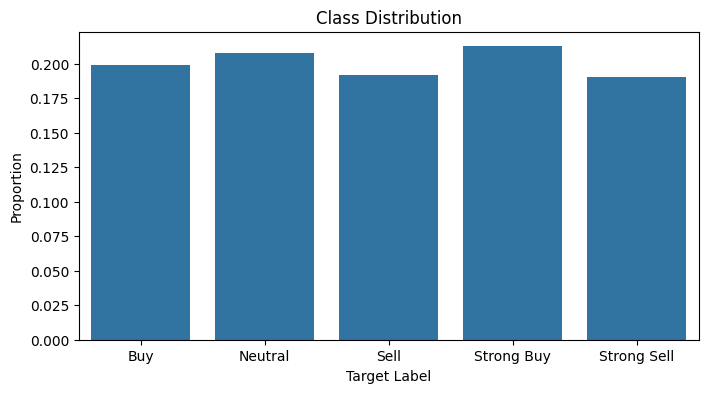

In [ ]:
# Plot Actual Class Distribution

class_counts = og_data2['target'].value_counts(normalize=True).sort_index()
print(class_counts)


plt.figure(figsize=(8, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Distribution")
plt.ylabel("Proportion")
plt.xlabel("Target Label")
plt.show()


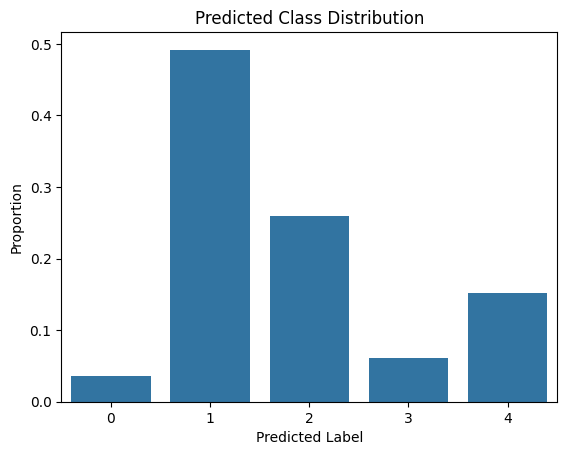

In [ ]:
from collections import Counter

# Plot predicted class distribution

pred_counts = pd.Series(y_pred).value_counts(normalize=True).sort_index()

sns.barplot(x=pred_counts.index, y=pred_counts.values)
plt.title("Predicted Class Distribution")
plt.ylabel("Proportion")
plt.xlabel("Predicted Label")
plt.show()
